# Multi-label classification using neural networks with a regularization
## Integrative Engineering, Digital Imaging 20175437 신준섭 Assignment 10

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp

file_path = "mnist.csv"

IMG_SZ_ROW, IMG_SZ_COL = 28, 28
TOTAL_IMG_SZ = IMG_SZ_ROW * IMG_SZ_COL

total_image, total_labels = [], []

with open(file_path, "r") as file_handler:
    raw_data = file_handler.readlines();
    for line in raw_data:
        img = line.split(',')
        total_image.append([*map(lambda x: (float(x) / 255.0), img[1:])])
        total_labels.append([int(img[0])])

total_image, total_labels = np.matrix(total_image), np.matrix(total_labels)

train_X, test_X = total_image[:1000,:].transpose(), total_image[1000:,:].transpose()

train_L = (np.eye(10)[total_labels[0:1000].reshape(-1)])[0].transpose()
test_L = (np.eye(10)[total_labels[1000:].reshape(-1)])[0].transpose()

train_X = np.concatenate((train_X, np.ones((1, 1000))))
test_X = np.concatenate((test_X, np.ones((1, 9000))))

## Sigmoid function as activation function

In [2]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def dev_sigmoid(z):
    return np.multiply(sigmoid(z), (1.0 - sigmoid(z)))

## Neural network architecture

In [3]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

def dev_sigmoid(z):
    return np.multiply(sigmoid(z), (1.0 - sigmoid(z)))

class Network:
    def __init__(self, reg_const):
        self.U = np.random.normal(0, 1, (196, 784 + 1))
        self.V = np.random.normal(0, 1, (49, 196 + 1))
        self.W = np.random.normal(0, 1, (10, 49 + 1))
        self.A = np.random.normal(0, 1, (10, 10))

        self.reg = reg_const
        self.num_par = self.U.shape[0] * self.U.shape[1] + self.V.shape[0] * self.V.shape[1] + self.W.shape[0] * self.W.shape[1] + self.A.shape[0] * self.A.shape[1]

    def getLoss(self, X, L):
        assert X.shape[1] == L.shape[1], "number of train data is not equal to label data"
        N = X.shape[1]
        u_ = np.matmul(self.U, X)
        u  = np.concatenate((sigmoid(u_), np.ones((1, N))))
        v_ = np.matmul(self.V, u)
        v  = np.concatenate((sigmoid(v_), np.ones((1, N))))
        w_ = np.matmul(self.W, v)
        w  = sigmoid(w_)
        a_ = np.matmul(self.A, w)
        a  = sigmoid(a_)
        
        reg_term = self.reg * (1.0 / (2.0 * self.num_par))  * (np.sum(np.power(self.U,2)) + np.sum(np.power(self.V, 2)) + np.sum(np.power(self.W, 2)) + np.sum(np.power(self.A, 2)))

        losses = np.multiply(-1.0 * L, np.log(a)) - np.multiply(1.0 - L, np.log(1.0 - a)) + reg_term
        
        return (1.0 / float(N)) * np.sum(losses)

    def getAccuracy(self, X, L):
        assert X.shape[1] == L.shape[1], "number of train data is not equal to label data"
        N = X.shape[1]

        u_ = np.matmul(self.U, X)
        u  = np.concatenate((sigmoid(u_), np.ones((1, N))))
        v_ = np.matmul(self.V, u)
        v  = np.concatenate((sigmoid(v_), np.ones((1, N))))
        w_ = np.matmul(self.W, v)
        w  = sigmoid(w_)
        a_ = np.matmul(self.A, w)
        a  = sigmoid(a_)

        max_a_indices = np.argmax(a, axis=0)
        max_l_indices = np.argmax(L, axis=0)

        hit, miss = 0, 0

        for i in range(N):
            if max_a_indices[0,i] == max_l_indices[i]:
                hit = hit + 1
            else:
                miss = miss + 1
        
        return float(hit) / (float(hit) + float(miss))

    def forwardPropagation(self, X, L):
        assert X.shape[1] == L.shape[1], "number of train data is not equal to label data"
        N = X.shape[1]

        self.u_ = np.matmul(self.U, X)
        self.u  = np.concatenate((sigmoid(self.u_), np.ones((1, N))))
        self.v_ = np.matmul(self.V, self.u)
        self.v  = np.concatenate((sigmoid(self.v_), np.ones((1, N))))
        self.w_ = np.matmul(self.W, self.v)        
        self.w  = sigmoid(self.w_)
        self.a_ = np.matmul(self.A, self.w)
        self.a  = sigmoid(self.a_)
        

        self.loss_mat = np.multiply(-1.0 * L, np.log(self.a)) - np.multiply(1.0 - L, np.log(1.0 - self.a))

        return (1.0 / float(N)) * np.sum(self.loss_mat)

    def backPropagation(self, X, L, lr = 0.01):
        N = X.shape[1]

        dJda  = np.divide(1.0 - L, 1.0 - self.a) - np.divide(L, self.a)
        dada_ = dev_sigmoid(self.a_)
        da_dA = self.w

        dJda_ = np.multiply(dJda, dada_)
        dJdA  = np.matmul(dJda_, da_dA.transpose())
        self.A = self.A - lr * (dJdA + (float(self.reg) / self.num_par) * self.A)

        da_dw = self.A
        dwdw_ = dev_sigmoid(self.w_)
        dw_dW = self.v

        dJdw  = np.matmul(da_dw.transpose(), dJda_)
        dJdw_ = np.multiply(dJdw, dwdw_)
        dJdW  = np.matmul(dJdw_, dw_dW.transpose())
        self.W = self.W - lr * (dJdW + (float(self.reg) / self.num_par) * self.W)

        dw_dv = self.W[:,:-1]
        dvdv_ = dev_sigmoid(self.v_)
        dv_dV = self.u

        dJdv  = np.matmul(dw_dv.transpose(), dJdw_)
        dJdv_ = np.multiply(dJdv, dvdv_)
        dJdV  = np.matmul(dJdv_, dv_dV.transpose())
        self.V = self.V - lr * (dJdV + (float(self.reg) / self.num_par) * self.V)

        dv_du = self.V[:,:-1]
        dudu_ = dev_sigmoid(self.u_)
        du_dU = X

        dJdu  = np.matmul(dv_du.transpose(), dJdv_)
        dJdu_ = np.multiply(dJdu, dudu_)
        dJdU  = np.matmul(dJdu_, du_dU.transpose())
        self.U = self.U - lr * (dJdU + (float(self.reg) / self.num_par) * self.U)
        

In [4]:
network = Network(0.1)

learning_rate = 0.001
lr_decay = 0.999

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

iterationss = 5000

for i in range(iterationss):
    network.forwardPropagation(train_X, train_L)
    network.getLoss(train_X, train_L)

    network.backPropagation(train_X, train_L, learning_rate)

    train_losses.append(network.getLoss(train_X, train_L))
    test_losses.append(network.getLoss(test_X, test_L))

    train_accuracies.append(network.getAccuracy(train_X, train_L) * 100.0)
    test_accuracies.append(network.getAccuracy(test_X, test_L) * 100.0)

    learning_rate = learning_rate * lr_decay


In [5]:
N = test_X.shape[1]

u_ = np.matmul(network.U, test_X)
u  = np.concatenate((sigmoid(u_), np.ones((1, N))))
v_ = np.matmul(network.V, u)
v  = np.concatenate((sigmoid(v_), np.ones((1, N))))
w_ = np.matmul(network.W, v)
w  = sigmoid(w_)
a_ = np.matmul(network.A, w)
a  = sigmoid(a_)

max_a_indices = np.argmax(a, axis=0)
max_l_indices = np.argmax(test_L, axis=0)

correct_sample, correct_ans = [], []
incorrect_sample, incorrect_ans = [], []

for i in range(N):
    if max_a_indices[0,i] == max_l_indices[i]:
        correct_sample.append(test_X[:-1,i].reshape((IMG_SZ_ROW, IMG_SZ_COL)))
        correct_ans.append(max_a_indices[0,i])
    else:
        incorrect_sample.append(test_X[:-1,i].reshape((IMG_SZ_ROW, IMG_SZ_COL)))
        incorrect_ans.append(max_a_indices[0,i])


## 1. Plot the loss curve

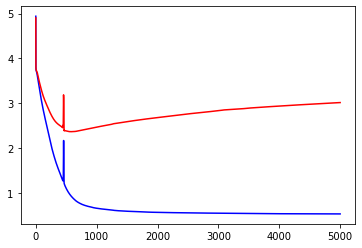

In [6]:
iter_x = list(range(iterationss))
plt.plot(iter_x, train_losses, color='blue')
plt.plot(iter_x, test_losses, color='red')
plt.show()

## 2. Plot the accuracy curve

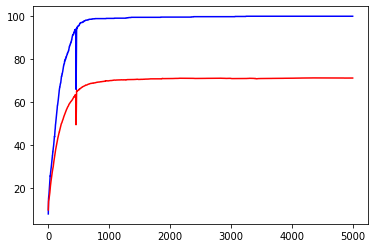

In [7]:
plt.plot(iter_x, train_accuracies, color='blue')
plt.plot(iter_x, test_accuracies, color='red')
plt.show()

## 3. Plot the accuracy value

In [8]:
print("final training accuracy : " + str(train_accuracies[-1])[:7] + "%")
print("final testing accuracy : " + str(test_accuracies[-1])[:7] + "%")

final training accuracy : 100.0%
final testing accuracy : 71.1777%


## 4. Plot the classification example

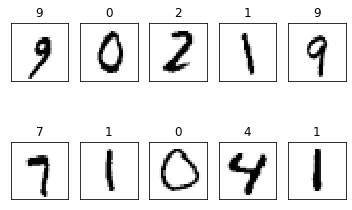

In [9]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(correct_ans[i])
    plt.imshow(correct_sample[i], cmap='Greys')
    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

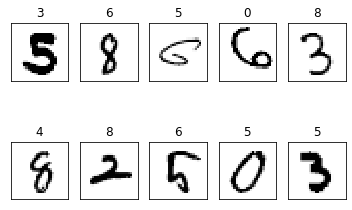

In [10]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title(incorrect_ans[i])
    plt.imshow(incorrect_sample[i], cmap='Greys')
    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

## 5. Testing accuracy

In [11]:
print("testing accuracy : " + str(test_accuracies[-1])[:7] + "%")

testing accuracy : 71.1777%
